In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# %load_ext autotime  # must be added to dependencies
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.insert(0, os.path.abspath('../src/'))

time: 13.8 ms (started: 2021-07-06 12:14:39 +02:00)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from structure_factor.structure_factor_new import StructureFactor
from structure_factor.spatstat_interface import SpatstatInterface
from structure_factor.spatial_windows import UnitBoxWindow


time: 1.9 s (started: 2021-07-06 12:14:39 +02:00)


# test the method  ``compute_scattering_intensity`` of the calss ``StructureFactor``

## loading data for test :
Poisson point process, Ginibre point pross, lattice $\mathbb{Z}^2$ matching processus of Michael Andreas Klatt, Günter Last, D. Yogeshwaran that we will denoted by kly defined in https://arxiv.org/abs/1810.00265

In [39]:
#importing big data
import pickle
import rpy2.robjects as robjects
path_data = "../data"
with open(os.path.join(path_data, "data_ginibre.dat"), "rb") as data:
    n_ginibre, ginibre = pickle.load(data, encoding="bytes")

robjects.r["load"](os.path.join(path_data, "../data/data_kly.dat"))
data_R_2 = robjects.r["out_2"]
data_kly_all = np.array(data_R_2)

time: 337 ms (started: 2021-07-06 15:21:33 +02:00)


We load big set of data that we already sample for time perpose. As we know that the method ``compute_scattering_intensity``work only for point configurations in **cubic windows** so for a point processes folling in a random window we will only take the points falling in a cubic window .
For example a configuration of the Ginibre point process is always contained in a ball, so we will project it to a cubic window.
To compare the effect of **dismissing points** we will test the poisson point process ``data_poisson_disk`` sampled in a disk via the function ``poisson_in_disk``   then projected to a cubic window ``data_poisson_cube_2`` and a poisson point process ``data_poisson_cube`` sampled directely in a cubic window  via the function ``poisson_in_rectangle``.

## Please consider using code from `homogeneous_poisson_process.py` and `spatial_windows.py` as presented in `Poisson-process-and-windows.ipynb`

In [4]:
def poisson_in_rectangle(xMin, xMax, yMin, yMax, lambda_p):
    xDelta = xMax - xMin;yDelta = yMax - yMin #rectangle dimensions
    areaTotal = xDelta * yDelta
    n_pois = scipy.stats.poisson(lambda_p * areaTotal).rvs()#Poisson number of points
    data_poisson_rectangle = np.zeros((n_pois, 2))
    xx = xDelta*scipy.stats.uniform.rvs(0, 1, ((n_pois, 1))) + xMin#x coordinates of Poisson points
    yy = yDelta*scipy.stats.uniform.rvs(0, 1, ((n_pois, 1))) + yMin#y coordinates of Poisson points
    data_poisson_rectangle[:,0] = xx[:,0]
    data_poisson_rectangle[:,1] = yy[:,0]
    return data_poisson_rectangle

time: 30.2 ms (started: 2021-07-06 12:14:44 +02:00)


In [5]:
L_poisson=200
data_poisson_cube = poisson_in_rectangle(-100, 100, -100, 100, lambda_p=1)

time: 32.4 ms (started: 2021-07-06 12:14:45 +02:00)


In [6]:
def poisson_in_disk(r, lambda_p):
    areaTotal = np.pi * r ** 2 #area of disk
    n_pois = np.random.poisson(lambda_p * areaTotal) #Poisson number of points
    data_poisson_disk = np.zeros((n_pois, 2))
    theta = 2 * np.pi * np.random.uniform(0, 1, n_pois) #angular coordinates 
    rho = r * np.sqrt(np.random.uniform(0, 1, n_pois))#radial coordinates 
    xx = rho * np.cos(theta)
    yy = rho * np.sin(theta)
    data_poisson_disk[:,0] = xx
    data_poisson_disk[:,1] = yy # rearrangement of poisson by increasing distance
    return data_poisson_disk

time: 27.9 ms (started: 2021-07-06 12:14:45 +02:00)


In [12]:
raduis_poisson = 300
data_poisson_disk = poisson_in_disk(r=r_poisson, lambda_p=1)

time: 48.9 ms (started: 2021-07-06 12:17:28 +02:00)


In [13]:
print("data_kly.shape", data_kly_all.shape)
print("data_poisson_disk.shape", data_poisson_disk.shape)
print("data_poisson_cube.shape", data_poisson_cube.shape)
print("data_ginibre.shape", ginibre.shape )

data_kly.shape (90000, 4)
data_poisson_disk.shape (282973, 2)
data_poisson_cube.shape (39835, 2)
data_ginibre.shape (10000, 1)
time: 30.2 ms (started: 2021-07-06 12:17:30 +02:00)


In [14]:
#load big data in the corresponding shape :math: `n /times 2`
data_ginibre = np.array([np.array(np.real(ginibre)).reshape(-1,), np.array(np.imag(ginibre)).reshape(-1,)]).T
data_kly = np.array([data_kly_all[:,0], data_kly_all[:,1]]).T
data_z_2 = np.array([data_kly_all[:,2], data_kly_all[:,3]]).T

time: 29.5 ms (started: 2021-07-06 12:17:31 +02:00)


In [15]:
#verifying the shape
print("data_kly.shape", data_kly.shape)
print("data_ginibre.shape", data_ginibre.shape )

data_kly.shape (90000, 2)
data_ginibre.shape (10000, 2)
time: 29.1 ms (started: 2021-07-06 12:17:31 +02:00)


data_poisson_cube.shape (45260, 2)
data_ginibre_cube.shape (10000, 2)


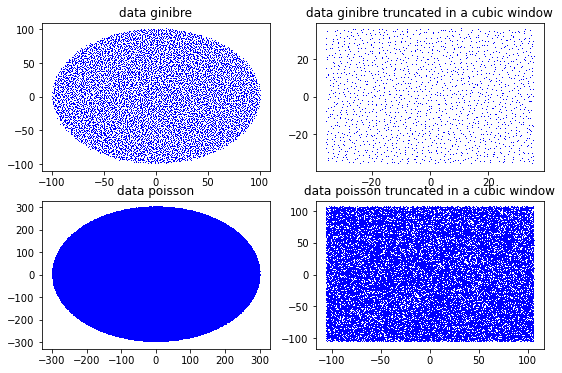

time: 353 ms (started: 2021-07-06 12:30:09 +02:00)


In [23]:
# truncating data_poisson and Ginibre in a cubic window
# poisson, and ginibre are contained in a ball while klatt and z_2 are in a rectangular window L = 300
L_poisson_2 = np.floor(raduis_poisson/np.sqrt(2))
index_poisson_in_cube = np.logical_and((np.abs(data_poisson_disk[:,0]) < (L_poisson_2/2)) , (np.abs(data_poisson_disk[:,1]) < (L_poisson_2/2)))
data_poisson_cube_2 = data_poisson_disk[index_poisson_in_cube]

raduis_ginibre = np.max(np.abs(ginibre))
L_ginibre = raduis_ginibre/np.sqrt(2)
index_ginibre_in_cube = np.logical_and((np.abs(data_ginibre[:,0]) < L_ginibre/2) , (np.abs(data_ginibre[:,1]) < L_ginibre/2))
data_ginibre_cube = data_ginibre[index_ginibre_in_cube]

print("data_poisson_cube.shape", data_poisson_cube_2.shape)
print("data_ginibre_cube.shape", data_ginibre.shape )
fig, ax = plt.subplots(2, 2, figsize=(9,6))
ax[0,0].plot(data_ginibre[:,0], data_ginibre[:,1], 'b,')
ax[0,0].title.set_text("data ginibre")
ax[0,1].plot(data_ginibre_cube[:,0], data_ginibre_cube[:,1], 'b,')
ax[0,1].title.set_text("data ginibre truncated in a cubic window")
ax[1,0].plot(data_poisson_disk[:,0], data_poisson_disk[:,1], 'b,')
ax[1,0].title.set_text("data poisson")
ax[1,1].plot(data_poisson_cube_2[:,0], data_poisson_cube_2[:,1], 'b,')
ax[1,1].title.set_text("data poisson truncated in a cubic window")

In [18]:
sf_poisson_cube = StructureFactor(data_poisson_cube, intensity=1 )
sf_poisson_cube_2 = StructureFactor(data_poisson_cube_2, intensity=1 )
sf_ginibre_cube = StructureFactor(data_ginibre_cube, intensity = 1/np.pi )
sf_kly = StructureFactor(data_kly, intensity= 1)
sf_z_2 = StructureFactor(data_z_2, intensity=1)

time: 30.4 ms (started: 2021-07-06 12:22:48 +02:00)


# for Poisson point process
we know that the pair correlation function and the structure factor of the Poisson point process are equal to 1 so we always plot the line  $𝑦=1$  representing the théoretical values for a Poisson point process

In [19]:
wave_length_poisson, scattering_intensity_poisson = sf_poisson_cube.compute_scattering_intensity(L=L_poisson,maximum_k =10,meshgrid_size=None)

time: 689 ms (started: 2021-07-06 12:23:02 +02:00)


the method ``plot_scattering_intensity`` take as input the output of the method ``compute_scattering_intensity`` to plot them.
also take as optional argument ``binning_parameter``correspnding to the parameters used for binning of ``si``, and ``exact_sf`` which the true sctructure factor function

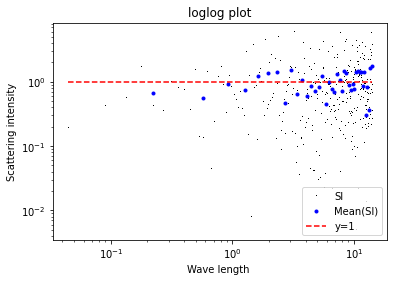

time: 522 ms (started: 2021-07-06 12:23:07 +02:00)


In [20]:
sf_poisson_cube.plot_scattering_intensity(wave_length_poisson.ravel(), scattering_intensity_poisson.ravel(), bins=40)

In [21]:
wave_length_poisson, scattering_intensity_poisson = sf_poisson_cube.compute_scattering_intensity(L=L_poisson,maximum_k =10,meshgrid_size=150)

time: 2min 14s (started: 2021-07-06 12:23:10 +02:00)


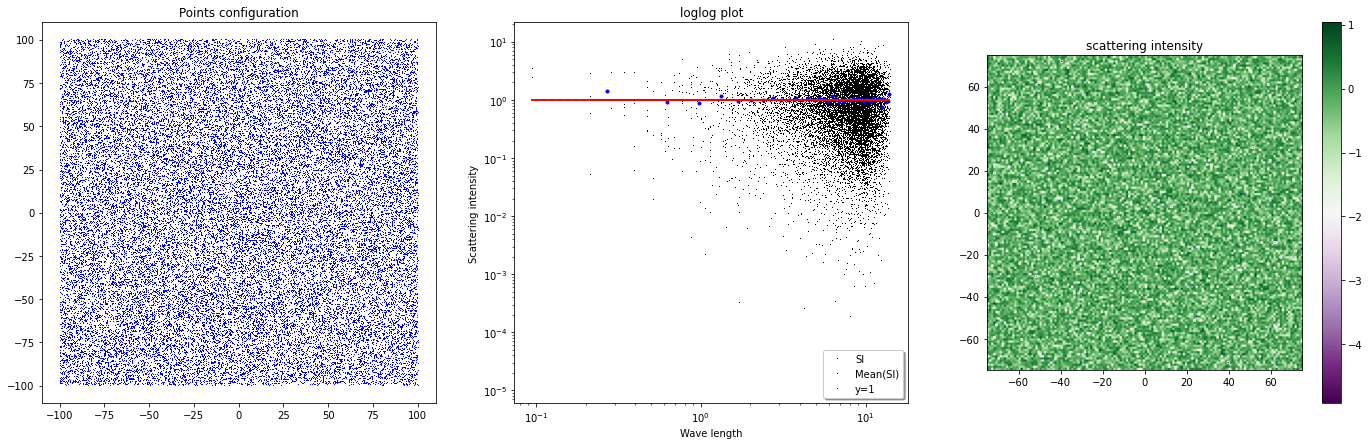

time: 1.43 s (started: 2021-07-06 12:29:20 +02:00)


In [22]:
sf_poisson_cube.plot_scattering_intensity(wave_length_poisson, scattering_intensity_poisson, plot_type="all",  bins=40, )

In [26]:
wave_length_poisson_2, scattering_intensity_poisson_2 = sf_poisson_cube_2.compute_scattering_intensity(L=L_poisson_2,maximum_k =10,meshgrid_size=150)

time: 2min 40s (started: 2021-07-06 12:38:18 +02:00)


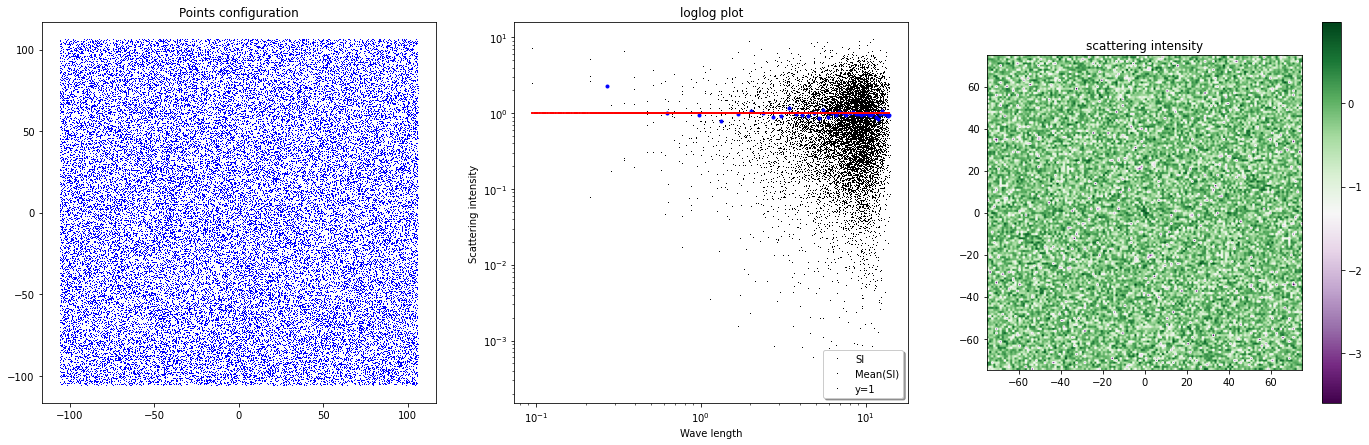

time: 1.12 s (started: 2021-07-06 12:41:02 +02:00)


In [27]:
sf_poisson_cube_2.plot_scattering_intensity(wave_length_poisson_2, scattering_intensity_poisson_2, plot_type="all",  bins=40 )

# for Ginibre point process

In [28]:
exact_sf_ginibre = lambda x : 1 - np.exp(-x**2/4) # exact structure factor for the Ginibre point process

time: 28.5 ms (started: 2021-07-06 12:41:17 +02:00)


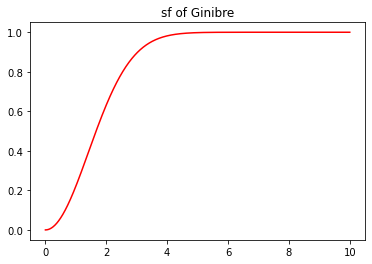

time: 124 ms (started: 2021-07-06 12:41:20 +02:00)


In [29]:
x=np.linspace(0,10, 1000)
plt.plot(x, exact_sf_ginibre(x), 'r')
plt.title("sf of Ginibre")
plt.show()

In [30]:
norm_k_ginibre, scattering_intensity_ginibre = sf_ginibre_cube.compute_scattering_intensity(L=L_ginibre,maximum_k =20)


time: 54.2 ms (started: 2021-07-06 12:41:22 +02:00)


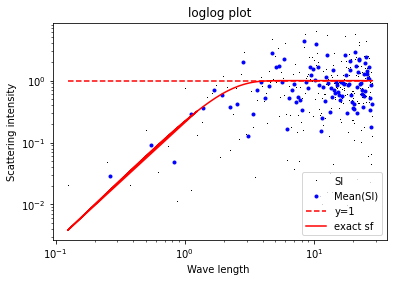

time: 385 ms (started: 2021-07-06 12:41:23 +02:00)


In [31]:
sf_ginibre_cube.plot_scattering_intensity(norm_k_ginibre, scattering_intensity_ginibre, plot_type="plot", exact_sf= exact_sf_ginibre, bins=100 )

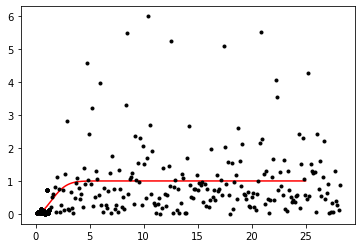

time: 149 ms (started: 2021-07-06 12:41:24 +02:00)


In [32]:
x=np.linspace(0,25, 1000)
plt.plot(x, exact_sf_ginibre(x), 'r', label="exat sf ginibre ")
plt.plot(norm_k_ginibre, scattering_intensity_ginibre, 'k.')
plt.show()

In [33]:
norm_k_ginibre_, scattering_intensity_ginibre_ = sf_ginibre_cube.compute_scattering_intensity(L=L_ginibre,maximum_k =10,meshgrid_size=300)

time: 5.57 s (started: 2021-07-06 12:41:25 +02:00)


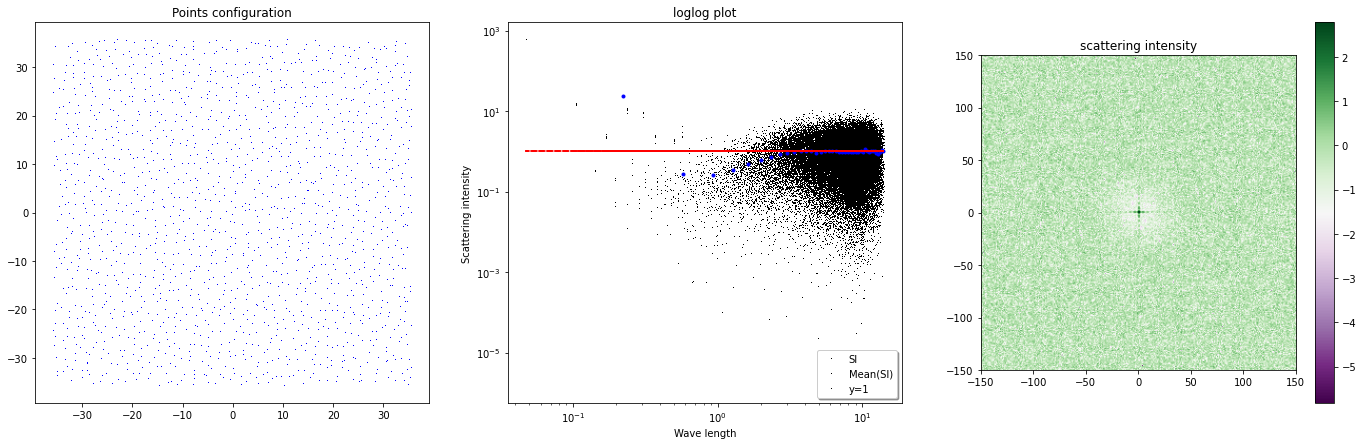

time: 1.37 s (started: 2021-07-06 12:41:32 +02:00)


In [34]:
sf_ginibre_cube.plot_scattering_intensity(norm_k_ginibre_, scattering_intensity_ginibre_, plot_type="all", bins=40 )

# for the processus of  Michael Andreas Klatt, Günter Last, D. Yogeshwaran that we will denoted by kly defined in https://arxiv.org/abs/1810.00265

In [35]:
norm_k_kly, si_kly = sf_kly.compute_scattering_intensity(L=300, maximum_k=20)

time: 3.61 s (started: 2021-07-06 12:41:41 +02:00)


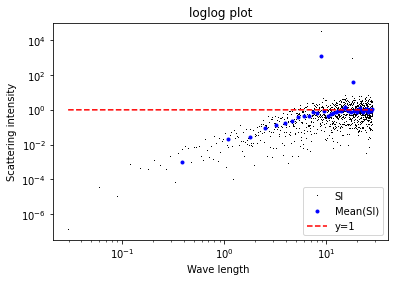

time: 517 ms (started: 2021-07-06 12:41:54 +02:00)


In [37]:
sf_kly.plot_scattering_intensity(norm_k_kly, si_kly, plot_type="plot", bins=40 )

In [38]:
norm_k_kly_, si_kly_ = sf_kly.compute_scattering_intensity(L=300, maximum_k=10, meshgrid_size=150)

time: 9min (started: 2021-07-06 12:41:59 +02:00)


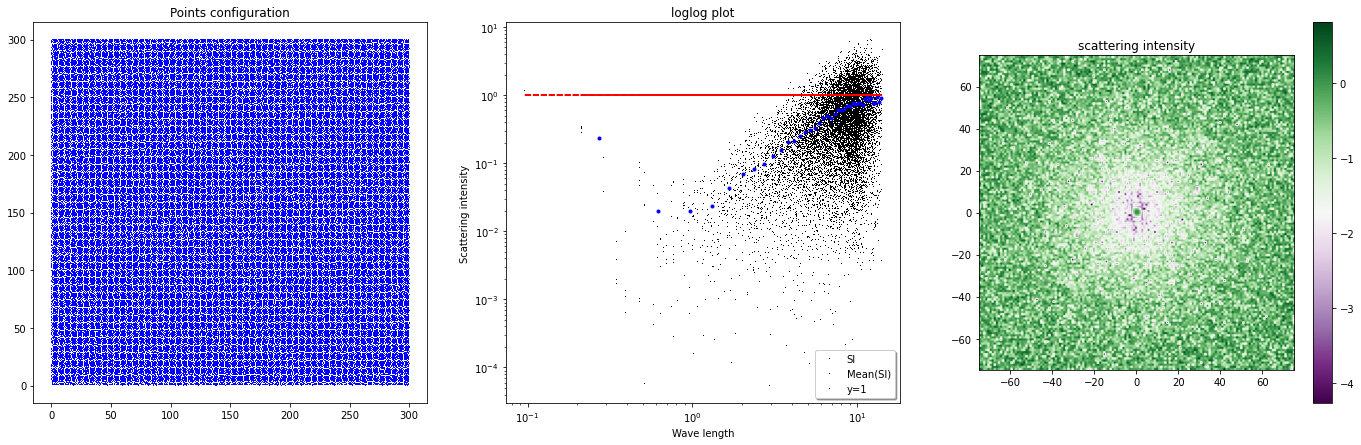

time: 1.67 s (started: 2021-07-06 08:25:33 +02:00)


In [125]:
sf_kly.plot_scattering_intensity(norm_k_kly_, si_kly_, plot_type="all", bins=40)

# for a lattice $\mathbb{Z}^2$

In [126]:
norm_k_z2, si_z2 = sf_z_2.compute_scattering_intensity(L=300, maximum_k=50)

time: 7.52 s (started: 2021-07-06 10:05:40 +02:00)


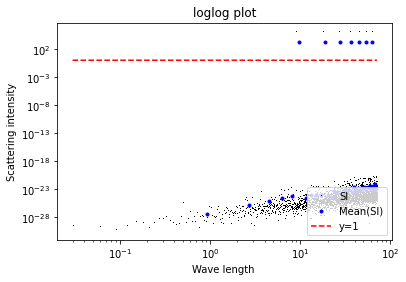

time: 375 ms (started: 2021-07-06 10:05:50 +02:00)


In [127]:
sf_z_2.plot_scattering_intensity(norm_k_z2, si_z2, plot_type="plot", bins=40 )

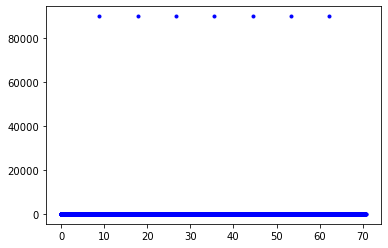

time: 104 ms (started: 2021-07-06 10:06:07 +02:00)


In [128]:
plt.plot(norm_k_z2, si_z2, 'b.')

In [129]:
norm_k_z2_, si_z2_ = sf_z_2.compute_scattering_intensity(L=300, maximum_k=20, meshgrid_size=150)

time: 7min 21s (started: 2021-07-06 10:07:14 +02:00)


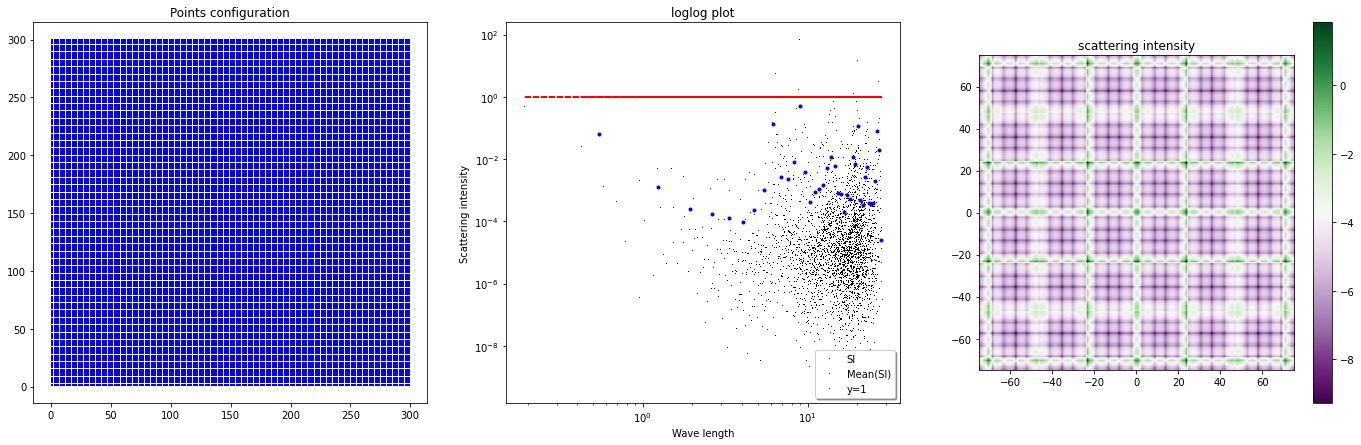

time: 1.12 s (started: 2021-07-06 10:15:08 +02:00)


In [130]:
sf_z_2.plot_scattering_intensity(norm_k_z2_, si_z2_, plot_type="all", bins=40)